# Tutorial de Clustering K-Means con Python y Scikit-learn

¡Bienvenido! Este notebook es un tutorial completo sobre el algoritmo de clustering **K-Means**, una de las técnicas más populares de aprendizaje no supervisado.

Aprenderás:
* Los fundamentos teóricos y matemáticos de K-Means.
* Cómo implementarlo usando la librería `scikit-learn` en Python.
* Un pipeline completo: preprocesamiento, entrenamiento, predicción y evaluación.

**Nota Importante:** K-Means es un algoritmo de **clustering (agrupamiento)**, no de **clasificación**. Su objetivo es encontrar grupos (clústeres) en los datos sin conocer etiquetas previas. Sin embargo, para *evaluar* qué tan bien funciona, a menudo lo aplicamos a un conjunto de datos que *sí* tiene etiquetas (como el dataset Iris) y comparamos los clústeres encontrados con las etiquetas reales. En este tutorial, usaremos métricas de clasificación (Matriz de Confusión, Accuracy) para este propósito de evaluación, pero ten en cuenta que esto no es un escenario de clasificación típico.

## 1.1 Fundamentos de la Técnica

**K-Means** es un algoritmo de **aprendizaje no supervisado** que agrupa un conjunto de datos en $K$ clústeres distintos (un número $K$ que debemos especificar de antemano).

El objetivo principal es particionar $N$ observaciones en $K$ clústeres, donde cada observación pertenece al clúster cuyo "centro" (llamado **centroide**) está más cercano.

El algoritmo funciona de forma iterativa:

1.  **Inicialización:** Elige $K$ puntos de datos aleatorios (o de forma inteligente) como los centroides iniciales.
2.  **Asignación:** Asigna cada punto de datos al clúster cuyo centroide esté más cerca (generalmente usando la distancia euclidiana).
3.  **Actualización:** Recalcula el centroide de cada clúster tomando el promedio de todos los puntos de datos asignados a ese clúster.
4.  **Iteración:** Repite los pasos 2 y 3 hasta que los centroides dejen de moverse significativamente o se alcance un número máximo de iteraciones.

El algoritmo busca minimizar la **inercia** (o *suma de cuadrados dentro del clúster*), que es la suma de las distancias al cuadrado de cada punto a su centroide asignado.

## 1.2 Modelo Matemático

El objetivo de K-Means es minimizar la **Suma de Cuadrados Dentro del Clúster** (WCSS), también conocida como **Inercia**.

La fórmula que K-Means intenta minimizar es:

$$
J = \sum_{k=1}^{K} \sum_{i \in C_k} ||x_i - \mu_k||^2
$$

Donde:
* $K$ es el número de clústeres.
* $C_k$ es el conjunto de todos los puntos de datos $x_i$ que pertenecen al clúster $k$.
* $\mu_k$ es el centroide del clúster $k$ (el promedio de todos los puntos en $C_k$).
* $||x_i - \mu_k||^2$ es la distancia euclidiana al cuadrado entre un punto de datos $x_i$ y el centroide de su clúster $\mu_k$.

## 1.3 Descripción de la Librería (Scikit-learn)

Para este tutorial, usaremos `scikit-learn`, la librería estándar de Machine Learning en Python.

* `sklearn.datasets.load_iris`: Usaremos este dataset clásico. Contiene 150 muestras de 3 especies de flores (Setosa, Versicolor, Virginica) con 4 características (longitud y ancho de sépalo y pétalo). Es ideal porque sabemos que $K=3$.
* `sklearn.cluster.KMeans`: Esta es la clase principal que implementa el algoritmo. Los parámetros clave son:
    * `n_clusters`: El número de clústeres $K$.
    * `init`: El método de inicialización de centroides (usualmente `'k-means++'` para una mejor convergencia).
    * `n_init`: El número de veces que el algoritmo se ejecutará con diferentes semillas de centroides. Se elegirá el mejor resultado. `'auto'` (o 10) es un buen valor.
    * `random_state`: Para asegurar que nuestros resultados sean reproducibles.
* `sklearn.metrics`: Contiene funciones para evaluar el rendimiento, como `confusion_matrix` y `accuracy_score`.
* `pandas` y `matplotlib`/`seaborn`: Para la manipulación y visualización de datos.

In [1]:
!pip install numpy pandas matplotlib scikit-learn seaborn

In [2]:
# Importación de librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score
import warnings

# Configuración de visualización
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')

print("Librerías importadas correctamente.")

Librerías importadas correctamente.


## 1.4 Pipeline de Implementación

Comenzaremos cargando los datos y siguiendo los pasos de un pipeline de clustering.

### Carga de Datos
Cargamos el dataset Iris y separamos las características (X) y las etiquetas verdaderas (y).

In [3]:
# Cargar el dataset Iris
iris = load_iris()
X = iris.data  # Las 4 características (features)
y = iris.target  # Las etiquetas verdaderas (0, 1, 2)
feature_names = iris.feature_names

print(f"Forma de los datos (X): {X.shape}")
print(f"Forma de las etiquetas (y): {y.shape}")
print(f"Clases (especies): {iris.target_names}")

Forma de los datos (X): (150, 4)
Forma de las etiquetas (y): (150,)
Clases (especies): ['setosa' 'versicolor' 'virginica']


### 1.4.1 Preprocesamiento

#### Análisis Estadístico
Primero, realicemos un análisis estadístico básico para entender la distribución de nuestras características.

In [4]:
# Convertir a DataFrame de Pandas para un análisis más fácil
df = pd.DataFrame(X, columns=feature_names)
df['species'] = y  # Añadimos las etiquetas reales para referencia

# Mapear los números de especie a sus nombres para una mejor leyenda
species_map = {0: 'setosa', 1: 'versicolor', 2: 'virginica'}
df['species_name'] = df['species'].map(species_map)

# Mostrar estadísticas descriptivas (avg, std, min, max, etc.)
print("Análisis Estadístico Descriptivo:")
print(df[feature_names].describe())

Análisis Estadístico Descriptivo:
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000           5.100000   
max             7.900000          4.400000           6.900000   

       petal width (cm)  
count        150.000000  
mean           1.199333  
std            0.762238  
min            0.100000  
25%            0.300000  
50%            1.300000  
75%            1.800000  
max            2.500000  


#### Gráfico de Dispersión (Scatter Plot)
Visualicemos los datos para ver si podemos identificar los clústeres visualmente. Usaremos las dos primeras características (longitud y ancho del sépalo) y colorearemos los puntos según su especie real (la etiqueta `y`).

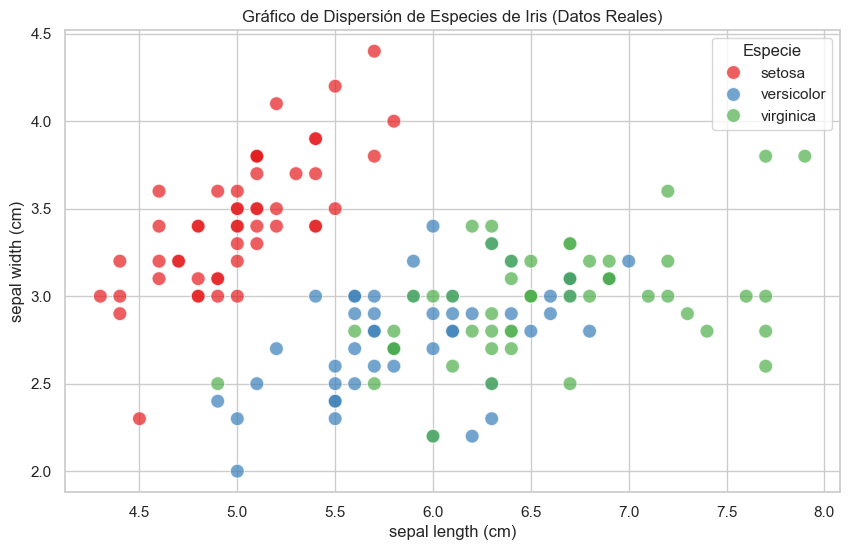

In [5]:
# Gráfico de Dispersión usando Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=df.iloc[:, 0],  # Longitud del sépalo
    y=df.iloc[:, 1],  # Ancho del sépalo
    hue=df['species_name'],
    palette='Set1',
    s=100,
    alpha=0.7
)
plt.title('Gráfico de Dispersión de Especies de Iris (Datos Reales)')
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])

plt.legend(title='Especie')

plt.show()

### Entrenamiento del Modelo K-Means
Ahora, entrenaremos nuestro modelo. Basado en el gráfico y nuestro conocimiento del dataset, sabemos que hay 3 especies, así que elegiremos $K=3$.

In [6]:
# Crear una instancia de KMeans
# n_clusters=3 porque sabemos que hay 3 especies de iris
# n_init=10 (o 'auto') para ejecutar el algoritmo 10 veces y elegir el mejor
# random_state=42 para reproducibilidad
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)

# Entrenar el modelo con nuestros datos (X)
# Nota: K-Means es no supervisado, ¡así que NO usamos 'y' aquí!
kmeans.fit(X)

# Obtener las etiquetas de clúster asignadas por K-Means
cluster_labels = kmeans.labels_

# Obtener las coordenadas de los centroides
centroids = kmeans.cluster_centers_

print("¡Modelo K-Means entrenado!")
print(f"Etiquetas de clúster asignadas (primeros 20): {cluster_labels[:20]}")
print("Centroides encontrados:")
print(centroids)

¡Modelo K-Means entrenado!
Etiquetas de clúster asignadas (primeros 20): [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Centroides encontrados:
[[5.9016129  2.7483871  4.39354839 1.43387097]
 [5.006      3.428      1.462      0.246     ]
 [6.85       3.07368421 5.74210526 2.07105263]]


### 1.4.2 Prediction
Ahora crearemos una función que puede tomar un nuevo patrón (una nueva flor) y predecir a qué clúster pertenecería.

In [7]:
def predecir_cluster(patron, modelo_kmeans):
    """
    Recibe un patrón (array de características) y un modelo KMeans entrenado,
    y devuelve el ID del clúster predicho.
    """
    # El modelo espera una entrada 2D, así que reformateamos [a, b, c, d] a [[a, b, c, d]]
    patron = np.array(patron).reshape(1, -1)
    
    # Usar el método .predict() del modelo
    cluster_predicho = modelo_kmeans.predict(patron)
    
    return cluster_predicho[0]

# --- Prueba de la función ---

# Ejemplo: Un patrón similar a la especie Setosa (valores bajos)
# [largo_sépalo, ancho_sépalo, largo_pétalo, ancho_pétalo]
patron_nuevo_1 = [5.0, 3.5, 1.4, 0.2]
clase_predicha_1 = predecir_cluster(patron_nuevo_1, kmeans)
print(f"El patrón {patron_nuevo_1} fue asignado al clúster: {clase_predicha_1}")

# Ejemplo: Un patrón similar a Virginica (valores altos)
patron_nuevo_2 = [6.7, 3.0, 5.2, 2.3]
clase_predicha_2 = predecir_cluster(patron_nuevo_2, kmeans)
print(f"El patrón {patron_nuevo_2} fue asignado al clúster: {clase_predicha_2}")

El patrón [5.0, 3.5, 1.4, 0.2] fue asignado al clúster: 1
El patrón [6.7, 3.0, 5.2, 2.3] fue asignado al clúster: 2


### 1.4.3 Model Evaluation
Aquí es donde comparamos los clústeres encontrados por K-Means (`cluster_labels`) con las etiquetas verdaderas (`y`).

**Importante:** K-Means no sabe que "Clúster 0" corresponde a "Especie 0". Podría asignar la "Especie 0" (Setosa) al "Clúster 1", la "Especie 1" (Versicolor) al "Clúster 2", etc.

Primero, debemos **mapear** las etiquetas del clúster a las etiquetas reales. Una forma fácil de ver esto es con una tabulación cruzada (`crosstab`).

In [8]:
# Crear una tabulación cruzada (matriz de contingencia)
# Filas = Etiquetas Reales (y)
# Columnas = Etiquetas de Clúster (cluster_labels)
ct = pd.crosstab(y, cluster_labels)

print("Tabla Cruzada (Real vs. Clúster):")
print(ct)

Tabla Cruzada (Real vs. Clúster):
col_0   0   1   2
row_0            
0       0  50   0
1      48   0   2
2      14   0  36


**Interpretación de la Tabla Cruzada:**

Observando la salida de la celda anterior:
* **Fila 0 (Especie Real 0 - Setosa):** Las 50 muestras cayeron en el **Clúster 1**.
* **Fila 1 (Especie Real 1 - Versicolor):** 48 muestras cayeron en el **Clúster 0** y 2 en el **Clúster 2**.
* **Fila 2 (Especie Real 2 - Virginica):** 36 muestras cayeron en el **Clúster 2** y 14 en el **Clúster 0**.

Esto nos da el siguiente **mapeo**:
* Especie Real 0 -> Clúster 1
* Especie Real 1 -> Clúster 0
* Especie Real 2 -> Clúster 2

Ahora, crearemos un nuevo array de etiquetas predichas (`mapped_labels`) que refleje este mapeo para poder calcular las métricas correctamente.

In [9]:
# Crear un array de ceros con la misma forma que cluster_labels
mapped_labels = np.zeros_like(cluster_labels)

# Aplicar el mapeo basado en la tabla cruzada
mapped_labels[cluster_labels == 1] = 0  # Clúster 1 es Especie 0
mapped_labels[cluster_labels == 0] = 1  # Clúster 0 es Especie 1
mapped_labels[cluster_labels == 2] = 2  # Clúster 2 es Especie 2

# (Nota: El mapeo exacto puede cambiar si se usa un random_state diferente)

#### Matriz de Confusión
La matriz de confusión nos permite ver en detalle cuántas predicciones fueron correctas y cuántas incorrectas, y de qué tipo.

Matriz de Confusión:
[[50  0  0]
 [ 0 48  2]
 [ 0 14 36]]


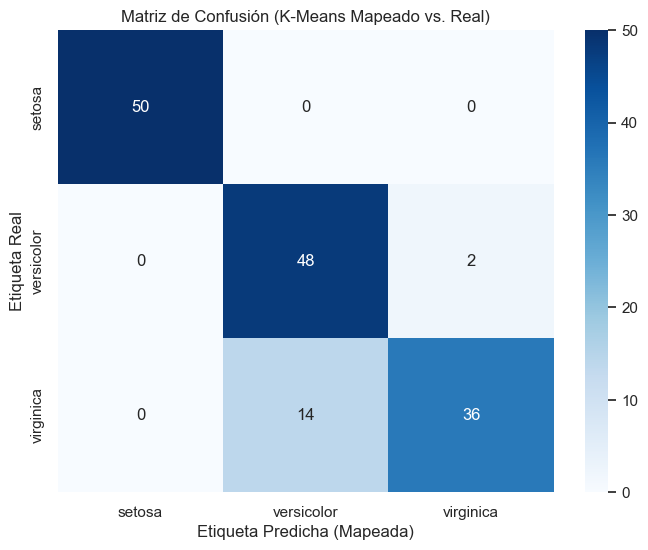

In [10]:
# Calcular la Matriz de Confusión
cm = confusion_matrix(y, mapped_labels)

print("Matriz de Confusión:")
print(cm)

# Visualizar la Matriz de Confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=iris.target_names,
            yticklabels=iris.target_names)
plt.title('Matriz de Confusión (K-Means Mapeado vs. Real)')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha (Mapeada)')
plt.show()

**Interpretación de la Matriz:**
* **Diagonal Principal (azul oscuro):** Muestra las predicciones correctas.
    * 50 Setosas fueron correctamente agrupadas.
    * 48 Versicolors fueron correctamente agrupadas.
    * 36 Virginicas fueron correctamente agrupadas.
* **Fuera de la Diagonal:** Muestra los errores.
    * 2 Versicolors fueron agrupadas incorrectamente como Virginica.
    * 14 Virginicas fueron agrupadas incorrectamente como Versicolor.

#### Accuracy (Exactitud)
El Accuracy nos da el porcentaje total de muestras que fueron agrupadas correctamente después del mapeo.

In [11]:
# Calcular el Accuracy
acc = accuracy_score(y, mapped_labels)

print(f"Accuracy del modelo K-Means: {acc * 100:.2f}%")

Accuracy del modelo K-Means: 89.33%


**Interpretación del Accuracy:**
Un accuracy del 89.33% significa que el algoritmo K-Means, sin ninguna supervisión, fue capaz de identificar correctamente la estructura subyacente de casi el 90% de los datos. Los errores (principalmente entre Versicolor y Virginica) son esperables, ya que estas dos especies son más similares entre sí que la especie Setosa (como vimos en el scatter plot inicial).

## Referencias Bibliográficas

1.  **Scikit-learn (KMeans):** Documentación oficial de la clase `sklearn.cluster.KMeans`.
    * [https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
2.  **Scikit-learn (Comparación de Métricas):** Comparación de métricas de evaluación de clustering (incluyendo el uso de ground truth).
    * [https://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation](https://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation)